# Image generation with Latent Consistency Model and OpenVINO

LCMs: The next generation of generative models after Latent Diffusion Models (LDMs). 
Latent Diffusion models (LDMs) have achieved remarkable results in synthesizing high-resolution images. However, the iterative sampling is computationally intensive and leads to slow generation.

Inspired by [Consistency Models](https://arxiv.org/abs/2303.01469), [Latent Consistency Models](https://arxiv.org/pdf/2310.04378.pdf) (LCMs) were proposed, enabling swift inference with minimal steps on any pre-trained LDMs, including Stable Diffusion. 
The [Consistency Model (CM) (Song et al., 2023)](https://arxiv.org/abs/2303.01469) is a new family of generative models that enables one-step or few-step generation. The core idea of the CM is to learn the function that maps any points on a trajectory of the PF-ODE (probability flow of [ordinary differential equation](https://en.wikipedia.org/wiki/Ordinary_differential_equation)) to that trajectory’s origin (i.e., the solution of the PF-ODE). By learning consistency mappings that maintain point consistency on ODE-trajectory, these models allow for single-step generation, eliminating the need for computation-intensive iterations. However, CM is constrained to pixel space image generation tasks, making it unsuitable for synthesizing high-resolution images. LCMs adopt a consistency model in the image latent space for generation high-resolution images.  Viewing the guided reverse diffusion process as solving an augmented probability flow ODE (PF-ODE), LCMs are designed to directly predict the solution of such ODE in latent space, mitigating the need for numerous iterations and allowing rapid, high-fidelity sampling. Utilizing image latent space in large-scale diffusion models like Stable Diffusion (SD) has effectively enhanced image generation quality and reduced computational load. The authors of LCMs provide a simple and efficient one-stage guided consistency distillation method named Latent Consistency Distillation (LCD) to distill SD for few-step (2∼4) or even 1-step sampling and propose the SKIPPING-STEP technique to further accelerate the convergence. More details about proposed approach and models can be found in [project page](https://latent-consistency-models.github.io/), [paper](https://arxiv.org/abs/2310.04378) and [original repository](https://github.com/luosiallen/latent-consistency-model).

In this tutorial, we consider how to convert and run LCM using OpenVINO. An additional part demonstrates how to run quantization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare models for OpenVINO format conversion](#Prepare-models-for-OpenVINO-format-conversion)
- [Convert models to OpenVINO format](#Convert-models-to-OpenVINO-format)
    - [Text Encoder](#Text-Encoder)
    - [U-Net](#U-Net)
    - [VAE](#VAE)
- [Prepare inference pipeline](#Prepare-inference-pipeline)
    - [Configure Inference Pipeline](#Configure-Inference-Pipeline)
- [Text-to-image generation](#Text-to-image-generation)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
        - [Compare UNet file size](#Compare-UNet-file-size)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/latent-consistency-models-image-generation/latent-consistency-models-image-generation.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [2]:
%pip install -U pip
%pip install -q "torch>=2.1" --index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2024.3.0" transformers "diffusers>=0.30.1" pillow "gradio>=4.19" "nncf>=2.12.0" "datasets>=2.14.6" --extra-index-url https://download.pytorch.org/whl/cpu

  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Prepare models for OpenVINO format conversion
[back to top ⬆️](#Table-of-contents:)

In this tutorial we will use [LCM_Dreamshaper_v7](https://huggingface.co/SimianLuo/LCM_Dreamshaper_v7) from [HuggingFace hub](https://huggingface.co/). This model distilled from [Dreamshaper v7](https://huggingface.co/Lykon/dreamshaper-7) fine-tune of [Stable-Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) using Latent Consistency Distillation (LCD) approach discussed above. This model is also integrated into [Diffusers](https://huggingface.co/docs/diffusers/index) library. 🤗 Diffusers is the go-to library for state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules. This allows us to compare running original Stable Diffusion (from this [notebook](../stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb)) and distilled using LCD. The distillation approach efficiently converts a pre-trained guided diffusion model into a latent consistency model by solving an augmented PF-ODE.

For starting work with LCM, we should instantiate generation pipeline first. `DiffusionPipeline.from_pretrained` method download all pipeline components for LCM and configure them. This model uses custom inference pipeline stored as part of model repository, we also should provide which module should be loaded for initialization using `custom_pipeline` argument and revision for it.

## Prepare inference pipeline
[back to top ⬆️](#Table-of-contents:)

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.

![lcm-pipeline](https://user-images.githubusercontent.com/29454499/277402235-079bacfb-3b6d-424b-8d47-5ddf601e1639.png)

The pipeline takes a latent image representation and a text prompt is transformed to text embedding via CLIP's text encoder as an input. The initial latent image representation generated using random noise generator. In difference, with original Stable Diffusion pipeline, LCM also uses guidance scale for getting timestep conditional embeddings as input for diffusion process, while in Stable Diffusion, it used for scaling output latents.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. LCM introduces own scheduling algorithm that extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with non-Markovian guidance.
The *denoising* process is repeated given number of times (by default 50 in original SD pipeline, but for LCM small number of steps required ~2-8) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

### Configure Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

First, you should create instances of OpenVINO Model and compile it using selected device. Select device from dropdown list for running inference using OpenVINO.

In [1]:
import torch
from diffusers import DiffusionPipeline

ov_pipe = DiffusionPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")
ov_pipe.text_encoder = torch.compile(ov_pipe.text_encoder, backend="openvino")
ov_pipe.unet =  torch.compile(ov_pipe.unet, backend="openvino")
ov_pipe.vae = torch.compile(ov_pipe.vae, backend="openvino")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
type(ov_pipe.unet._orig_mod)

diffusers.models.unets.unet_2d_condition.UNet2DConditionModel

## Text-to-image generation
[back to top ⬆️](#Table-of-contents:)

Now, let's see model in action

In [2]:
prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4
torch.manual_seed(1234567)

images = ov_pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=8.0,
    lcm_origin_steps=50,
    output_type="pil",
    height=512,
    width=512,
).images

  0%|          | 0/4 [00:00<?, ?it/s]

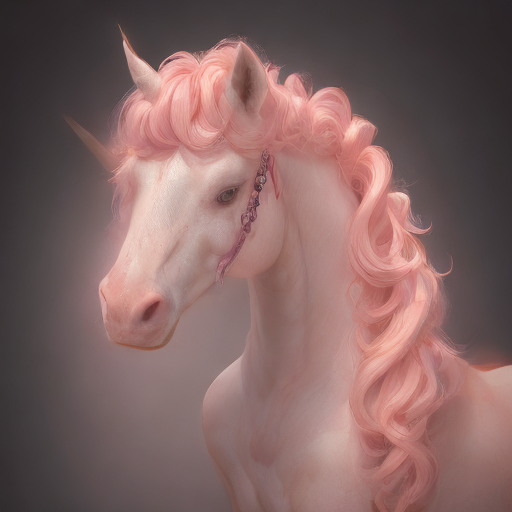

In [3]:
images[0]

Nice. As you can see, the picture has quite a high definition 🔥.

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `LatentConsistencyModelPipeline` structure, UNet used for iterative denoising of input. It means that model runs in the cycle repeating inference on each diffusion step, while other parts of pipeline take part only once. That is why computation cost and speed of UNet denoising becomes the critical path in the pipeline. Quantizing the rest of the SD pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [2]:
int8_pipe = None

# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)
%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [conceptual_captions](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [2]:
import datasets
from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List
import numpy as np
from copy import deepcopy

set_seed(1)

num_inference_steps = 4
def collect_calibration_data(lcm_pipeline: DiffusionPipeline, subset_size: int) -> List[Dict]:
    lcm_pipeline.unet
    prob = 0.3
    calibration_dataset = []
    def patched_forward(*args, **kwargs):
        if np.random.rand() >= prob:
            calibration_dataset.append((args[0], args[1], kwargs["encoder_hidden_states"]))
        return lcm_pipeline.unet._original_forward(*args, **kwargs)

    assert not hasattr(lcm_pipeline.unet, "_original_call")
    lcm_pipeline.unet._original_forward = lcm_pipeline.unet.forward
    lcm_pipeline.unet.forward = patched_forward

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)
    lcm_pipeline.set_progress_bar_config(disable=True)
    safety_checker = lcm_pipeline.safety_checker
    lcm_pipeline.safety_checker = None

    # Run inference for data collection
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > lcm_pipeline.tokenizer.model_max_length:
            continue
        _ = lcm_pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=8.0,
            lcm_origin_steps=50,
            output_type="pil",
            height=512,
            width=512,
        )
        collected_subset_size = len(calibration_dataset)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    lcm_pipeline.set_progress_bar_config(disable=False)

    lcm_pipeline.unet.forward = lcm_pipeline.unet._original_forward
    #del lcm_pipeline.unet._original_forward

    lcm_pipeline.safety_checker = safety_checker
    return calibration_dataset

In [3]:
import logging
from pathlib import Path

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

subset_size = 1
unet_calibration_data = collect_calibration_data(ov_pipe, subset_size=subset_size)

  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
import torch

unet_calibration_data = [[]]

for shape in [[1, 4, 64, 64], [], [1, 77, 768]]:
    unet_calibration_data[0].append(torch.ones(shape))

unet_calibration_data[0] = tuple(unet_calibration_data[0])

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [8]:
import sys
sys.path.append("/home/dlyakhov/Projects/nncf")

In [9]:
from nncf.torch import disable_patching
with disable_patching():
    exported_unet = torch.export.export(ov_pipe.unet, args=unet_calibration_data[0]).module()

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


In [3]:
exported_unet = torch.export.export(ov_pipe.unet, args=unet_calibration_data[0]).module()
ov_pipe.unet = exported_unet

In [4]:
prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4
torch.manual_seed(1234567)

images = ov_pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=8.0,
    lcm_origin_steps=50,
    output_type="pil",
    height=512,
    width=512,
).images
images[0]

AttributeError: 'GraphModule' object has no attribute 'config'

In [11]:
from nncf.common.factory import NNCFGraphFactory
NNCFGraphFactory.create(exported_unet).visualize_graph("nncf_graph.dot")

In [6]:
from torch.fx.passes.graph_drawer import FxGraphDrawer
import torch

def visualize_fx_model(model: torch.fx.GraphModule, output_svg_path: str):
    g = FxGraphDrawer(model, output_svg_path)
    g.get_dot_graph().write_svg(output_svg_path)

In [7]:
visualize_fx_model(exported_unet, "exported_unet.svg")

KeyboardInterrupt: 

In [5]:
import nncf
from nncf.torch import disable_patching

with disable_patching():
    exported_unet = torch.export.export(ov_pipe.unet, args=unet_calibration_data[0]).module()
    quantized_unet = nncf.quantize(
        model=exported_unet,
        subset_size=subset_size,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        model_type=nncf.ModelType.TRANSFORMER,
        ignored_scope=nncf.IgnoredScope(types=["__getitem__"]),
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


Output()

Output()

INFO:nncf:32 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 449 getitem
INFO:nncf:Not adding activation input quantizer for operation: 450 getitem_1
INFO:nncf:Not adding activation input quantizer for operation: 560 getitem_2
INFO:nncf:Not adding activation input quantizer for operation: 561 getitem_3
INFO:nncf:Not adding activation input quantizer for operation: 677 getitem_4
INFO:nncf:Not adding activation input quantizer for operation: 678 getitem_5
INFO:nncf:Not adding activation input quantizer for operation: 788 getitem_6
INFO:nncf:Not adding activation input quantizer for operation: 789 getitem_7
INFO:nncf:Not adding activation input quantizer for operation: 905 getitem_8
INFO:nncf:Not adding activation input quantizer for operation: 906 getitem_9
INFO:nncf:Not adding activation input quantizer for operation: 1016 getitem_10
INFO:nncf:Not adding activation input quantizer for operation: 1017 getitem_11
INFO:nncf:

Output()

In [6]:
import torch
from diffusers import DiffusionPipeline

int8_pipe = DiffusionPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")
int8_pipe.text_encoder = torch.compile(int8_pipe.text_encoder, backend="openvino")
int8_pipe.unet =  torch.compile(quantized_unet, backend="openvino")
int8_pipe.vae = torch.compile(ov_pipe.vae, backend="openvino")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Let us check predictions with the quantized UNet using the same input data.

In [7]:
from IPython.display import display

prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4
torch.manual_seed(1234567)

images = int8_pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=8.0,
    lcm_origin_steps=50,
    output_type="pil",
    height=512,
    width=512,
).images

display(images[0])

AttributeError: 'GraphModule' object has no attribute 'config'

### Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [20]:
%%skip not $to_quantize.value

import time

validation_size = 10
calibration_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True)
validation_data = []
for idx, batch in enumerate(calibration_dataset):
    if idx >= validation_size:
        break
    prompt = batch["caption"]
    validation_data.append(prompt)

def calculate_inference_time(pipeline, calibration_dataset):
    inference_time = []
    pipeline.set_progress_bar_config(disable=True)
    for idx, prompt in enumerate(validation_data):
        start = time.perf_counter()
        _ = pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=8.0,
            lcm_origin_steps=50,
            output_type="pil",
            height=512,
            width=512,
        )
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
        if idx >= validation_size:
            break
    return np.median(inference_time)

In [21]:
%%skip not $to_quantize.value

fp_latency = calculate_inference_time(ov_pipe, validation_data)
int8_latency = calculate_inference_time(int8_pipe, validation_data)
print(f"Performance speed up: {fp_latency / int8_latency:.3f}")

Performance speed up: 1.319


#### Compare UNet file size
[back to top ⬆️](#Table-of-contents:)


In [22]:
%%skip not $to_quantize.value

fp16_ir_model_size = UNET_OV_PATH.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = UNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 1024

print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 1678912.37 KB
INT8 model size: 840792.93 KB
Model compression rate: 1.997


## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [23]:
import random
import gradio as gr
from functools import partial

MAX_SEED = np.iinfo(np.int32).max


def randomize_seed_fn(seed: int, randomize_seed: bool) -> int:
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)
    return seed


def generate(
    pipeline: OVLatentConsistencyModelPipeline,
    prompt: str,
    seed: int = 0,
    width: int = 512,
    height: int = 512,
    guidance_scale: float = 8.0,
    num_inference_steps: int = 4,
    randomize_seed: bool = False,
    num_images: int = 1,
    progress=gr.Progress(track_tqdm=True),
):
    seed = randomize_seed_fn(seed, randomize_seed)
    torch.manual_seed(seed)
    result = pipeline(
        prompt=prompt,
        width=width,
        height=height,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        num_images_per_prompt=num_images,
        lcm_origin_steps=50,
        output_type="pil",
    ).images[0]
    return result, seed


generate_original = partial(generate, ov_pipe)
generate_optimized = partial(generate, int8_pipe)
quantized_model_present = int8_pipe is not None
generate = generate_optimized if quantized_model_present else generate_original

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/latent-consistency-models-image-generation/gradio_helper.py"
    )
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo_lcm

demo = make_demo_lcm(fn=generate, quantized=quantized_model_present)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()